# <font color='green'>Bike Sharing Demand</font>


### Objetivo

> Prever a demanda de aluguel de bicicletas por hora da cidade de Washington D.C a partir de dados meteorológicos históricos. 
O dataset de treino e teste são referentes aos anos de 2011 e 2012, respectivamente.



### Base de dados

#### Colunas:

- **season**: estação do ano

    - 1 = primavera
    - 2 = verão
    - 3 = outono
    - 4 = inverno

- **month**: mês [1->12]

- **hour**: hora [0->23]

- **holiday**: se o dia é considerado feriado

- **weekday**: dia da semana [0->6]

- **workingday**: se é um dia útil
- **weather**: tempo
    - 1 = Céu limpo, poucas nuvens
    - 2 = Névoa + Nublado
    - 3 = chuva fraca + trovoada 
    - 4 = Chuva forte 
- **temp**: temperatura em Celsius
- **feel_temp**: sensação térmica em Celcius
- **humidity**: umidade relativa
- **windspeed**: velocidade do vento
- **count**: número total de aluguéis

------

#### Etapas:
1) EDA, limpeza e preparação dos dados, modelagem e avaliação

2) Crie um pipeline utilizando o framework do Sklearn

3) No Colab, desenvolva e valide o código para registrar métricas, parâmetros, artefatos e pipeline com o MLflow. Obs: Você pode visualizar as runs e os registros com o comando `mlflow.search_runs()` para validar o seu código. 

4) Isto feito, extraia o notebook como um arquivo .py 

5) No VSCode, crie um arquivo requirements.txt com as bibliotecas utilizadas e as devidas versões

3) Crie um ambiente vitual com as dependências (bibliotecas com as devidas versões) a partir do arquivo requirements.txt;

4) Insira o notebook desenvolvido no Colab e renomeie para train.py

5) Execute o arquivo train.py no terminal -> `python train.py`

6) No terminal, execute o seguinte comando para acessar o servidor do MLflow e visualizar os resultados -> `mlflow ui` 

7) Crie um arquivo chamado app.py para que ele consuma o modelo registrado pelo MLflow e possa fazer as predições -> `mlflow.sklearn.load_model()`

8) No arquivo app.py, crie uma aplicação Flask que recebe uma requisição de método POST que receba como entrada os dados do arquivo **input_data.json** (mude a ordem das colunas se necessário) e retorne a previsão do modelo em formato de string.

8) Para rodar a aplicação execute: 
- `set FLASK_APP=app.py`
- `flask run`

9) Visualize o resultado da predição utilizando a extansão Thunder ou digitando o endereço no seu próprio Browser

-----

**<font color='green'>DICA:** O target (variável count) possui uma distribuição assimétrica/curva. Transforme-o aplicando o log ou a raiz quadrada para obter uma distribuição mais próxima da normal. 

## Bike Sharing Demand

# Exploratory Analysis

In [81]:
import seaborn as sns
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor

Loading

In [82]:
train=pd.read_csv('../data/train_bikes.csv')
test=pd.read_csv('../data/test_bikes.csv')

Shape train and Test

In [83]:
train.shape , test.shape

((10886, 12), (6493, 9))

Summary Statistics

In [84]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57
std,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14
min,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,4.00,1.00,1.00,4.00,41.00,45.45,100.00,57.00,367.00,886.00,977.00


We don't have nulls values

In [85]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In this case, let's add some columns provided by the datetime. We can drop 'datetime' after that.

In [86]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['weekday'] = train['datetime'].dt.weekday
train.drop(columns=['datetime'] ,inplace=True)
train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,weekday
0,1,0,0,1,9.84,14.39,81,0.00,3,13,16,0,1,5
1,1,0,0,1,9.02,13.63,80,0.00,8,32,40,1,1,5
2,1,0,0,1,9.02,13.63,80,0.00,5,27,32,2,1,5
3,1,0,0,1,9.84,14.39,75,0.00,3,10,13,3,1,5
4,1,0,0,1,9.84,14.39,75,0.00,0,1,1,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.70,50,26.00,7,329,336,19,12,2
10882,4,0,1,1,14.76,17.43,57,15.00,10,231,241,20,12,2
10883,4,0,1,1,13.94,15.91,61,15.00,4,164,168,21,12,2
10884,4,0,1,1,13.94,17.43,61,6.00,12,117,129,22,12,2


Same thing to test Dataset.

In [87]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month
test['weekday'] = test['datetime'].dt.weekday
test.drop(columns=['datetime'] ,inplace=True)
test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,weekday
0,1,0,1,1,10.66,11.37,56,26.00,0,1,3
1,1,0,1,1,10.66,13.63,56,0.00,1,1,3
2,1,0,1,1,10.66,13.63,56,0.00,2,1,3
3,1,0,1,1,10.66,12.88,56,11.00,3,1,3
4,1,0,1,1,10.66,12.88,56,11.00,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.88,60,11.00,19,12,0
6489,1,0,1,2,10.66,12.88,60,11.00,20,12,0
6490,1,0,1,1,10.66,12.88,60,11.00,21,12,0
6491,1,0,1,1,10.66,13.63,56,9.00,22,12,0


Let's plot a pairplot with the histogram type diagonal.

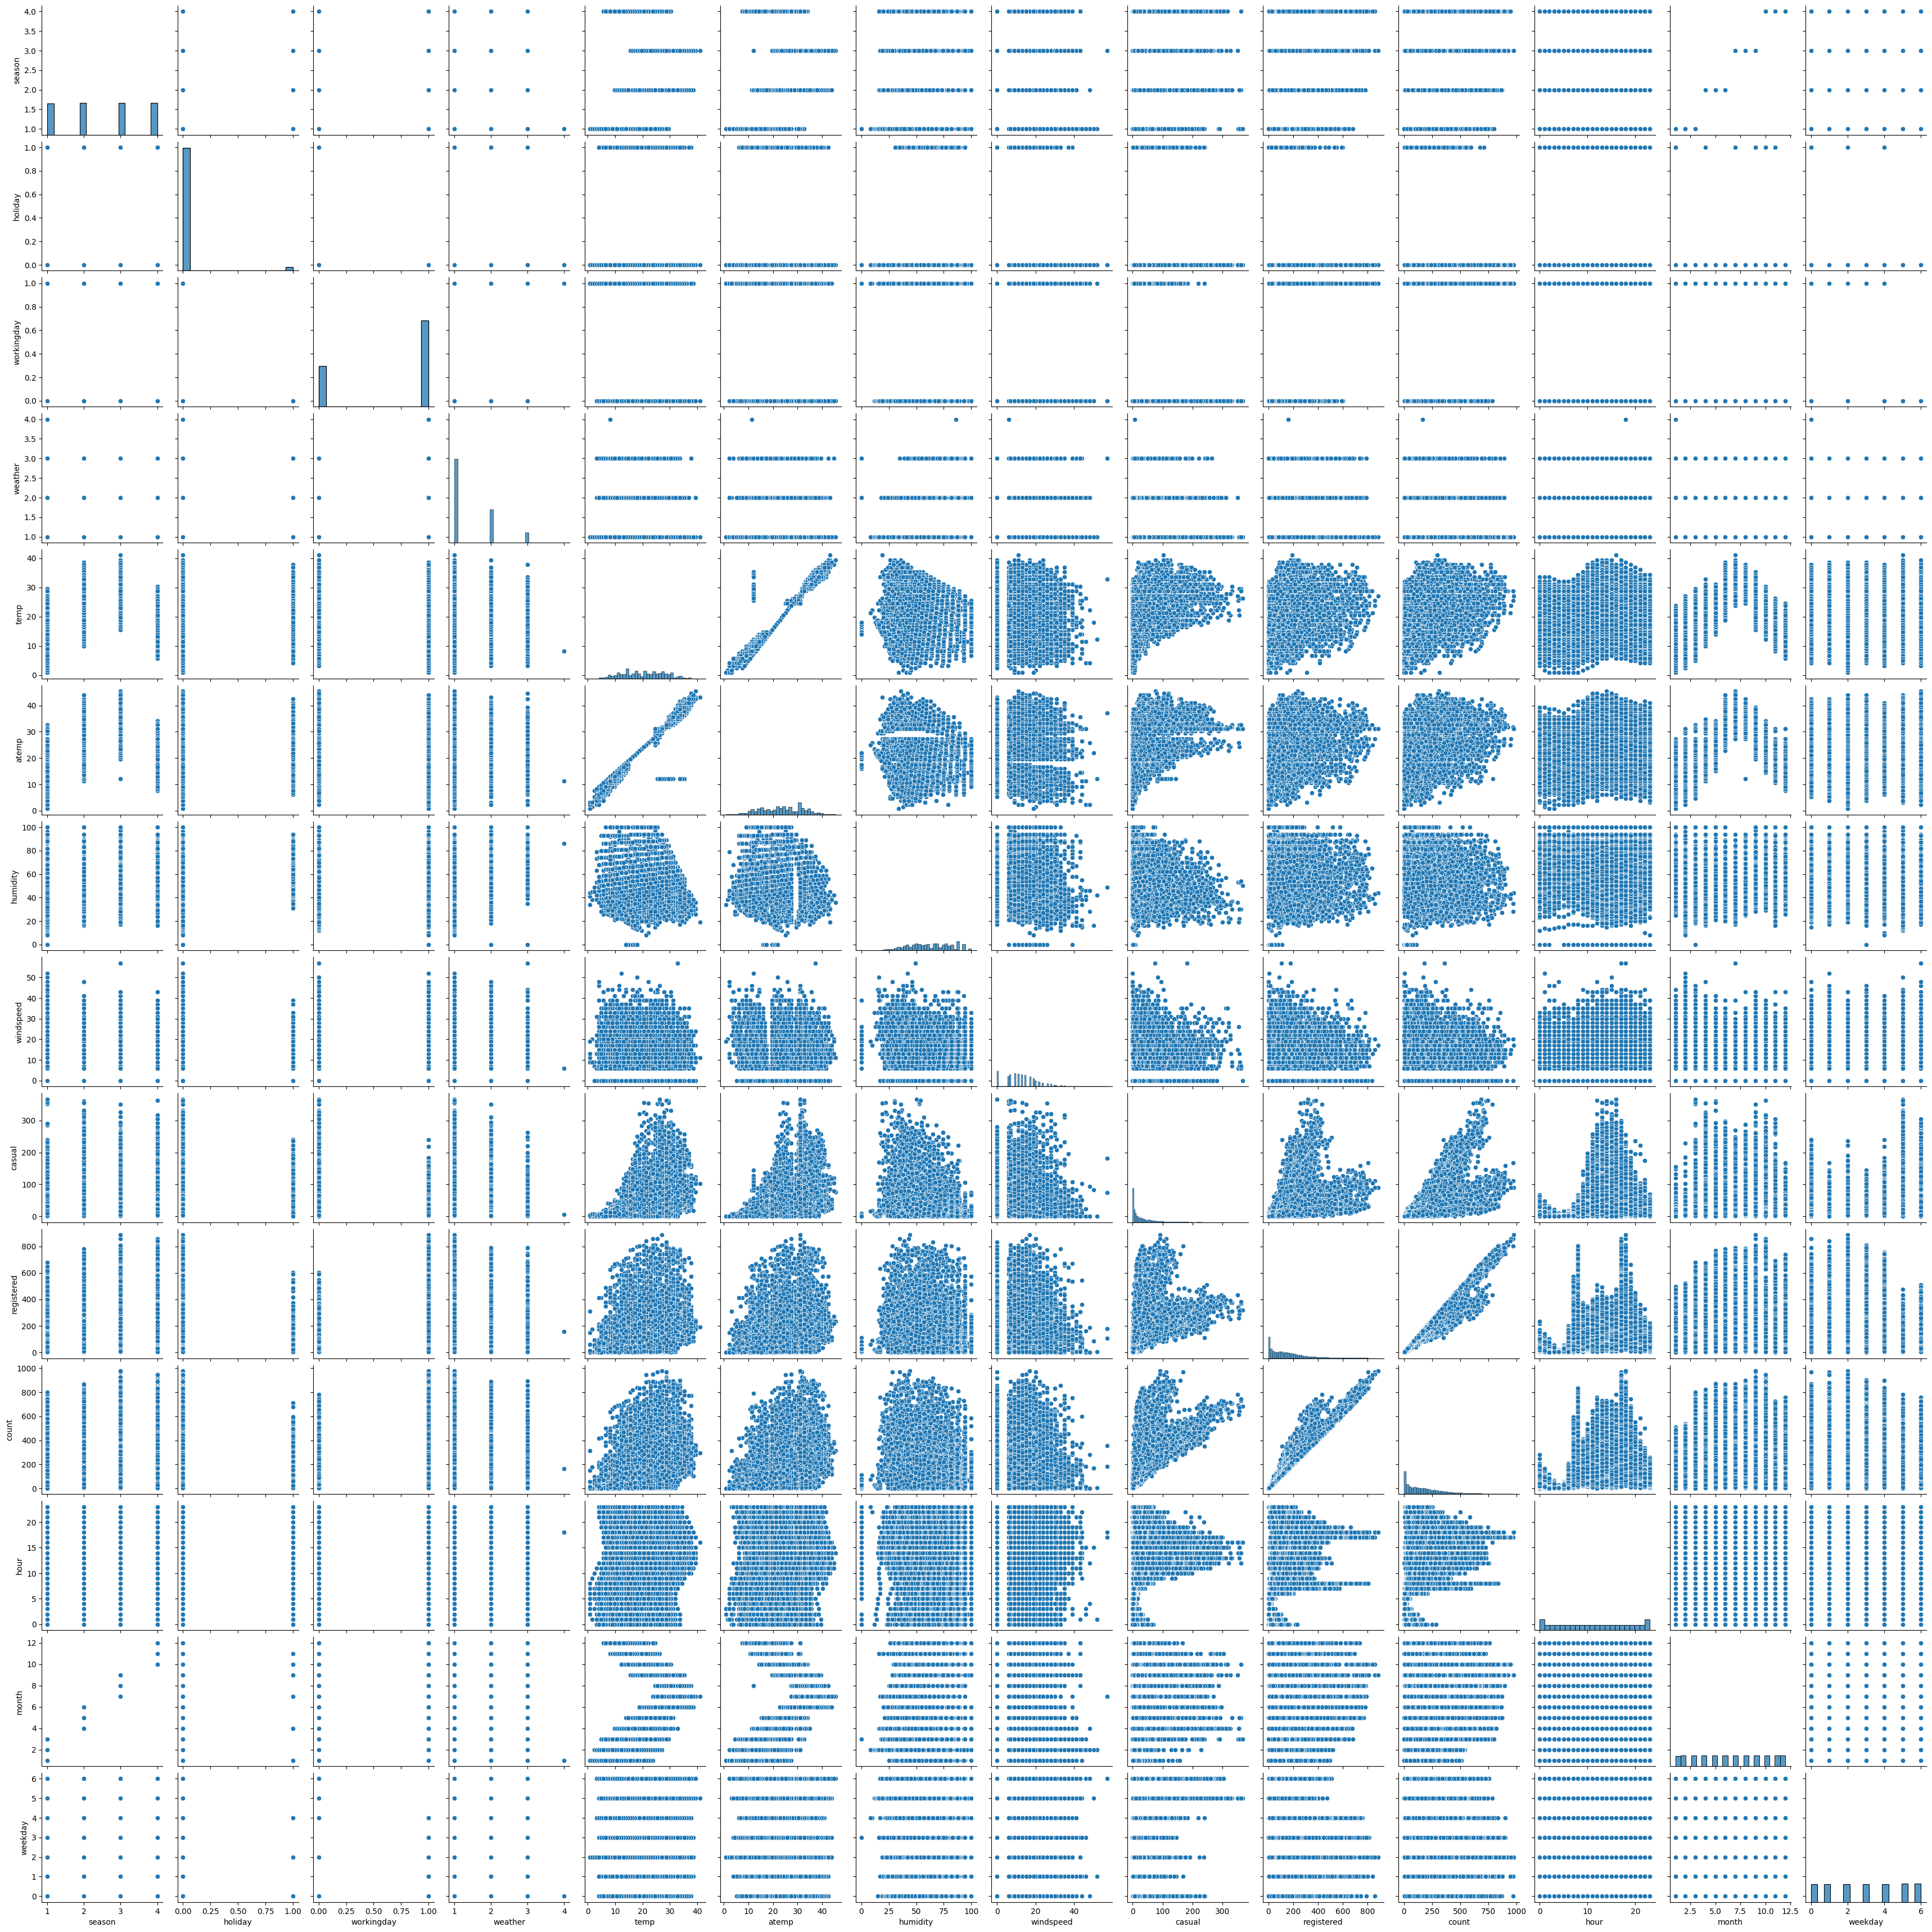

In [88]:
sns.pairplot(train,diag_kind='hist')

Histogram of our target feature.

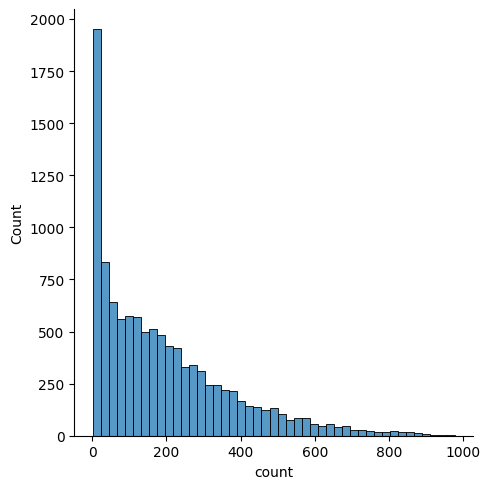

In [89]:
sns.displot(train['count'])

So, we do not have a distribution that we're searching for. In this case, we can transform with log and see what happens.

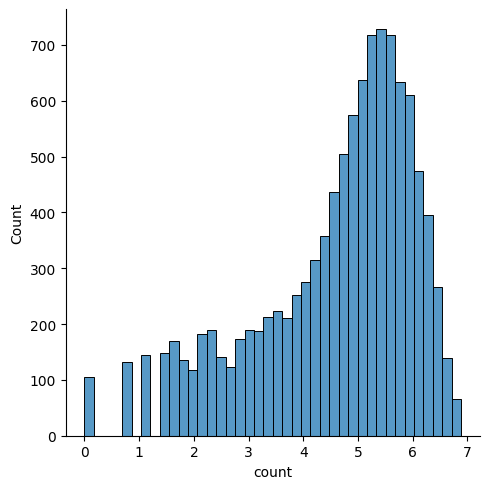

In [90]:
sns.displot(np.log(train['count']))

It's better with a log transformation. Let's apply that. Continuing with the exploration, we can graphically visualize how the count occurs by grouping by day of the week and hour.

In [91]:
mean_hour=train.groupby(['hour','weekday'])['count'].mean().reset_index()
mean_hour

,hour,weekday,count
0,0,0,35.49
1,0,1,27.33
2,0,2,36.25
3,0,3,37.48
4,0,4,53.23
...,...,...,...
163,23,2,80.14
164,23,3,99.63
165,23,4,119.55
166,23,5,120.03


Let's plot that.

<AxesSubplot: xlabel='weekday', ylabel='count'>

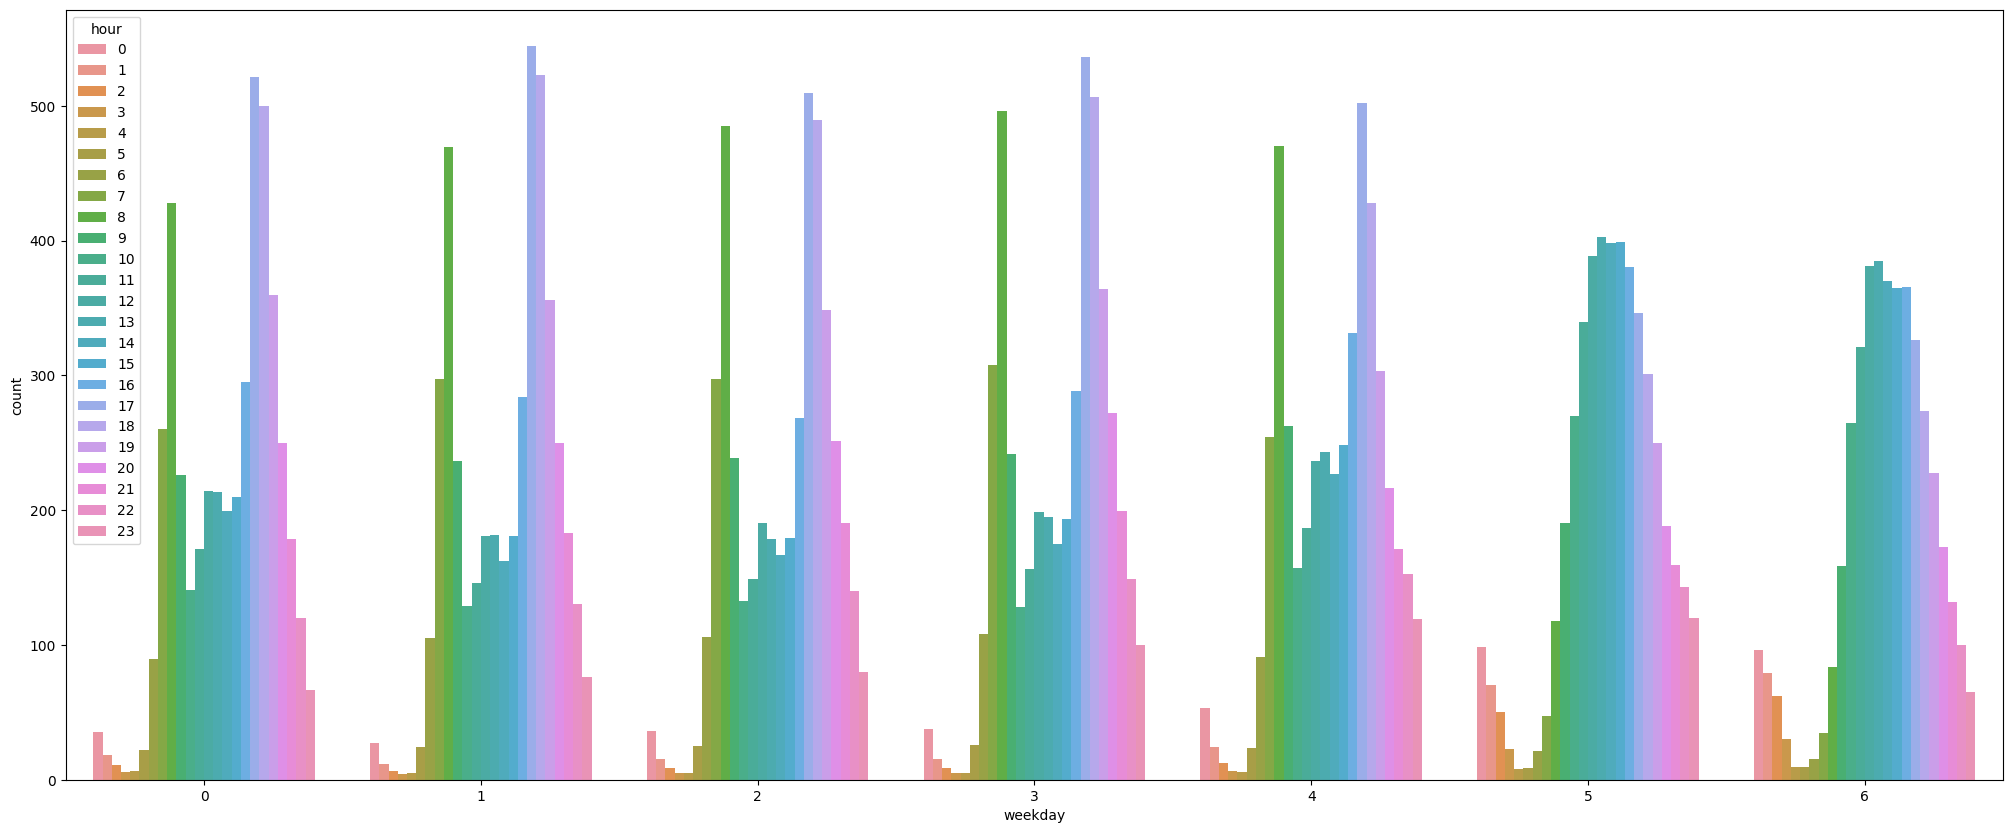

In [92]:
plt.figure(figsize=(25,10))
sns.barplot(x='weekday',y='count',data=mean_hour,hue='hour')

We can see that on workdays, we have higher occurrences at 5 pm. On weekends, around 1 pm.

In relation to the month, we have higher occurrences in 6, that is, June.

<AxesSubplot: xlabel='month', ylabel='count'>

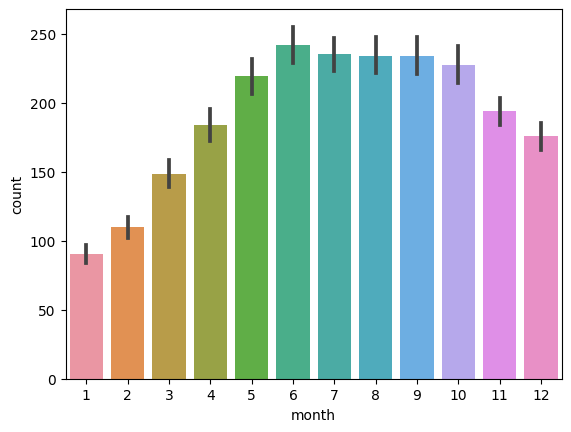

In [93]:
sns.barplot(x='month',y='count',data=train)

In relation to the season, we have higher occurrences in 3, that is, autumn.

<AxesSubplot: xlabel='season', ylabel='count'>

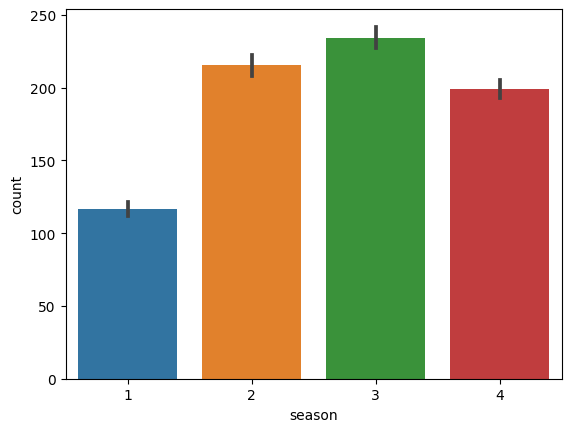

In [94]:
sns.barplot(x='season',y='count',data=train)

Let's take a look at the correlation plot.

<AxesSubplot: >

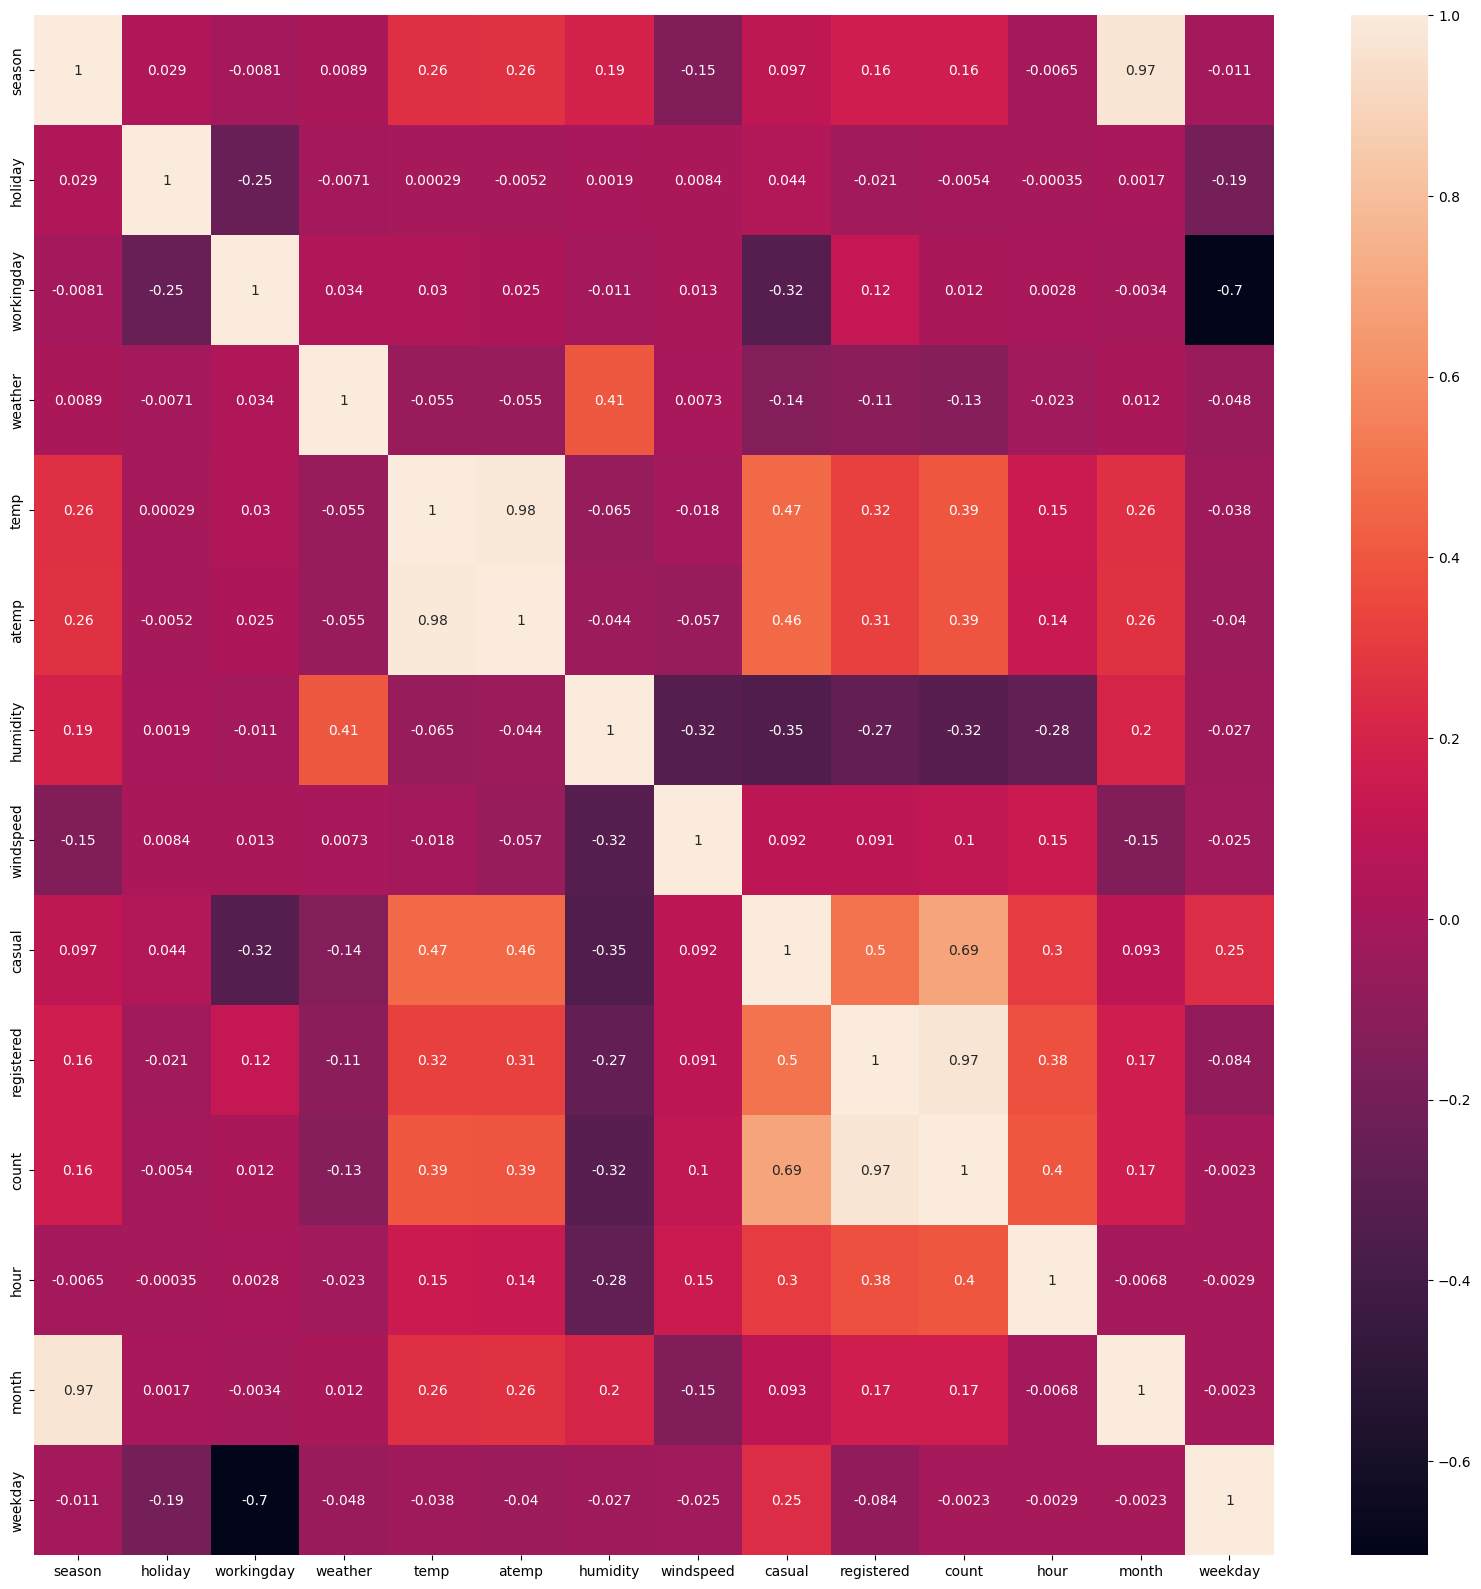

In [95]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True)

# Feature Emgineering

I would like to build a column that shows us whether the occurrence is during rush hour or not, categorized as 0 or 1. Let's create a function for that.

In [96]:
def rush_hour(X):
  df=X.copy()
  c1=((df['weekday'].isin([0,6])) & ((df['hour']>=10) & (df['hour']<=17)))
  c2=((df['weekday'].isin([0,6])==False) & (((df['hour']>=17) & (df['hour']<=19)) | (df['hour']==8)))
  df['peak']=np.where(c1,1,np.where(c2,1,0))
  return df

This is a function called rush_hour that takes in a pandas DataFrame X as input and returns a modified copy of it.

The function first creates two boolean conditions c1 and c2 based on the values in the weekday and hour columns of the DataFrame. These conditions are used to identify rush hours, which are typically times of the day when traffic is heaviest.

c1 represents rush hours during weekends (i.e., weekdays 0 and 6, which correspond to Sunday and Saturday, respectively) from 10:00 AM to 5:00 PM.

c2 represents rush hours during weekdays (i.e., weekdays 1-5) from 5:00 PM to 7:00 PM, and also from 8:00 AM to 9:00 AM (which is often considered a peak hour for traffic).

The function then creates a new column called pico in the DataFrame using the np.where() function. If c1 or c2 is true for a particular row, the corresponding value of pico is set to 1. Otherwise, pico is set to 0.

 # Modeling

We split the data in training and test

In [97]:
from sklearn.model_selection import train_test_split

X = train[['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'month', 'weekday']]
y = train[['count']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
X_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,weekday
613,1,0,1,1,9.02,9.09,32,39.00,17,2,1
4030,3,0,0,1,22.14,25.76,68,13.00,23,9,6
3582,3,0,1,1,26.24,28.79,83,0.00,4,8,4
10101,4,0,1,1,9.02,11.37,69,9.00,6,11,1
1430,2,0,1,3,13.12,14.39,81,30.00,11,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5734,1,0,0,1,6.56,8.34,47,11.00,2,1,5
5191,4,0,0,1,11.48,12.88,61,19.00,9,12,5
5390,4,0,0,1,11.48,13.63,48,17.00,16,12,6
860,1,0,0,1,15.58,19.70,17,35.00,7,2,5


In [99]:
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
# models,predictions = reg.fit(X_train, X_test, y_train, y_test)

## Pipeline

So, as we discussed before, we can transform the target with log. To do that, let's produce a function to that and use it in the pipeline.

In [100]:
def log_target(target):
  return np.log(target)

def exp_log(target):
  return np.exp(target)

In [101]:
pipeline=Pipeline([
          ('transformer_pico', FunctionTransformer(rush_hour)),
          ('target_transform_plus_regressor',TransformedTargetRegressor(regressor=RandomForestRegressor(),func=log_target,inverse_func=exp_log))
])

This is a machine learning pipeline that applies a custom function to the input data, standardizes the data, and then uses a Random Forest Regressor to make predictions on a transformed target variable.

In [102]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer_pico',
                 FunctionTransformer(func=<function rush_hour at 0x000001874BF8F6D0>)),
                ('target_transform_plus_regressor',
                 TransformedTargetRegressor(func=<function log_target at 0x000001874C01B760>,
                                            inverse_func=<function exp_log at 0x000001874BF8E440>,
                                            regressor=RandomForestRegressor()))])

In [103]:

y_pred_train=pipeline.predict(X_train)
y_pred_test=pipeline.predict(X_test)

In [104]:
print(f' r2 test score: {r2_score(y_test,y_pred_test)}')
print(f' r2 train score: {r2_score(y_train,y_pred_train)}')

 r2 test score: 0.8571014352104334
 r2 train score: 0.9760892282379492


In [105]:
print(f' Test MRE: {mean_squared_error(y_test,y_pred_test)}')
print(f' Train MRE: {mean_squared_error(y_train,y_pred_train)}')

 Test MRE: 4649.9614749644
 Train MRE: 787.2833564339136


Cross Validation Value

The bike share demand dataset is a time series problem because it involves predicting the number of bikes that will be rented at a given time, which can vary depending on the day of the week, season, weather conditions, and other factors. To evaluate the performance of a machine learning model for this problem, it is important to use a time series cross-validation approach, such as the TimeSeriesSplit method with n_splits=5, to ensure that the model is not overfitting to specific time periods in the dataset.

In [106]:
cv=TimeSeriesSplit(n_splits=5)
score=cross_val_score(pipeline,X_train,y_train,scoring='r2',cv=cv)
score

array([0.77448461, 0.78957622, 0.83585745, 0.84777251, 0.84040142])

In the provided code, a pipeline is used to preprocess the data and fit a regression model to predict the bike rental count. The cross_val_score function is used to calculate the R-squared score for each fold of the time series cross-validation, which measures the proportion of variance in the target variable (i.e., bike rental count) that is explained by the model. The resulting scores can be used to evaluate the overall performance of the model and compare different models or hyperparameters.

In [107]:
score.mean()

0.817618439967956

# MLflow Metrics

In this part, we will save graphs, evaluation metrics, and the model using MLflow.

In [108]:
import mlflow
from mlflow.models.signature import infer_signature

Set and run the mlflow experiment

In [109]:
mlflow.set_experiment('Prediction Bike')
mlflow.start_run()

<ActiveRun: >

Saving the first Graphic

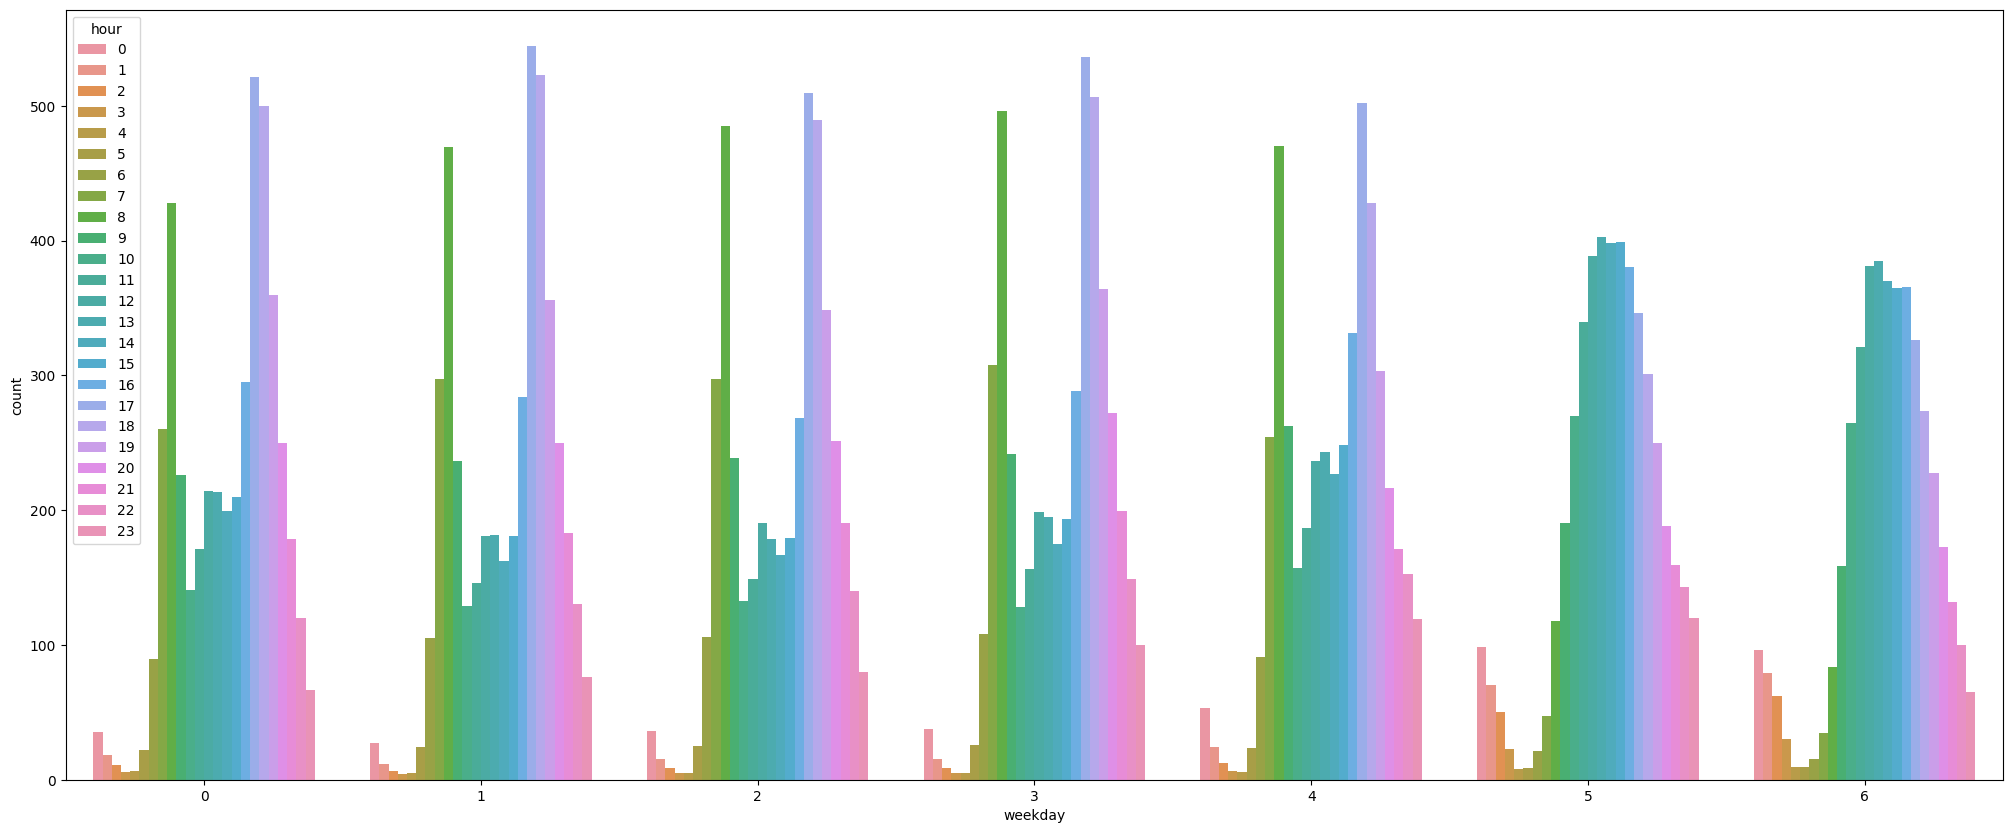

In [110]:
plt.figure(figsize=(25,10))
sns.barplot(x='weekday',y='count',data=mean_hour,hue='hour')
plt.savefig("../notebook/mlruns/graph_hours.png")
mlflow.log_artifact("../notebook/mlruns/graph_hours.png")

In [111]:
plt.close()

Second Graphic

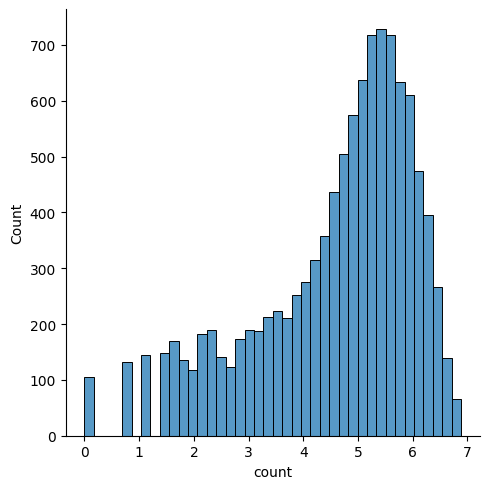

In [112]:
sns.displot(np.log(train['count']))
plt.savefig("../notebook/mlruns/target.png")
mlflow.log_artifact("../notebook/mlruns/target.png")

In [113]:
plt.close()

Loading metrics

In [114]:
r2 = r2_score(y_test,y_pred_test)
mre = mean_squared_error(y_test,y_pred_test)
cv=TimeSeriesSplit(n_splits=5)
score = cross_val_score(pipeline,X_train,y_train,scoring='r2',cv=cv)
score = score.mean()

In [115]:
mlflow.log_metric('r2 test', r2)
mlflow.log_metric('Mean Squared Error',mre)
mlflow.log_metric('Cross Validation Mean',score)


Model

In [116]:
mlflow.sklearn.log_model(pipeline,"model_pipeline")

Loading Params

In [117]:
params = pipeline.named_steps['target_transform_plus_regressor'].get_params()

In [118]:
mlflow.log_params(params)

Finishing 

In [119]:
mlflow.end_run()

In [128]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Mean Squared Error,metrics.r2 test,metrics.Cross Validation Mean,params.regressor__random_state,...,params.regressor__n_jobs,params.func,params.regressor__criterion,params.regressor__ccp_alpha,params.regressor__bootstrap,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.source.type
0,8f18ad6773ca4035a5cbd7403b32e6b4,729910338415843698,FINISHED,file:///c:/Users/felip/Desktop/bike-end-to-end...,2023-03-16 15:07:57.049000+00:00,2023-03-16 15:08:15.072000+00:00,4649.96,0.86,0.82,None,...,None,<function log_target at 0x000001874C01B760>,squared_error,0.0,True,felip,able-fowl-426,C:\Users\felip\AppData\Local\Packages\PythonSo...,"[{""run_id"": ""8f18ad6773ca4035a5cbd7403b32e6b4""...",LOCAL
1,2803cae31e1541b7acbdf74f25ca6c86,729910338415843698,FINISHED,file:///c:/Users/felip/Desktop/bike-end-to-end...,2023-03-15 19:36:35.320000+00:00,2023-03-15 19:37:10.388000+00:00,4626.59,0.86,0.82,None,...,None,<function log_target at 0x0000025940094820>,squared_error,0.0,True,felip,learned-dove-642,C:\Users\felip\AppData\Local\Packages\PythonSo...,"[{""run_id"": ""2803cae31e1541b7acbdf74f25ca6c86""...",LOCAL


As we always want to work with the latest version of the model, we created an artifact for this.

In [129]:
last_run = dict(mlflow.search_runs().sort_values(by='start_time',ascending=False).iloc[0])
artifact = last_run['artifact_uri']

Now, let's try load the latest version of the model provided by MLflow.

In [130]:
model = mlflow.sklearn.load_model(artifact+"/model_pipeline")

Let's try

In [131]:
model

Pipeline(steps=[('transformer_pico',
                 FunctionTransformer(func=<function rush_hour at 0x0000018753FAFF40>)),
                ('target_transform_plus_regressor',
                 TransformedTargetRegressor(func=<function log_target at 0x0000018753FAFB50>,
                                            inverse_func=<function exp_log at 0x0000018753FAF010>,
                                            regressor=RandomForestRegressor()))])

In [132]:
model.predict(X_test)

array([[156.68129503],
       [  7.28866961],
       [106.83898081],
       ...,
       [213.33331659],
       [156.82592617],
       [  2.45271862]])

As we can see, we loaded the model perfectly.

# Flask APP with the test Data

In [125]:
test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,weekday
0,1,0,1,1,10.66,11.37,56,26.00,0,1,3
1,1,0,1,1,10.66,13.63,56,0.00,1,1,3
2,1,0,1,1,10.66,13.63,56,0.00,2,1,3
3,1,0,1,1,10.66,12.88,56,11.00,3,1,3
4,1,0,1,1,10.66,12.88,56,11.00,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.88,60,11.00,19,12,0
6489,1,0,1,2,10.66,12.88,60,11.00,20,12,0
6490,1,0,1,1,10.66,12.88,60,11.00,21,12,0
6491,1,0,1,1,10.66,13.63,56,9.00,22,12,0


Selecting the first row to test our Flask App with this data.

In [134]:
test.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'month', 'weekday'],
      dtype='object')

In [126]:
test.iloc[0]

season        1.00
holiday       0.00
workingday    1.00
weather       1.00
temp         10.66
atemp        11.37
humidity     56.00
windspeed    26.00
hour          0.00
month         1.00
weekday       3.00
Name: 0, dtype: float64

In [127]:
import json

data = test.iloc[0].to_dict()
json_string = json.dumps(data)

# Escrever string JSON em um arquivo
with open('data.json', 'w') as f:
    f.write(json_string)